# Práctica 2 - Redes Neuronales Artificiales con Keras.

Vamos a entrenar una MLP profunda en el dataset MNIST buscando el mejor ratio de aprendizaje mediante la técnica de crecimiento exponencial y encontrando el punto donde la pérdida se dispara. Vamos a intenta llegar al 98% de precisión aplicando todas las mejores: guardando puntos de control, utilizando parada temprana, y finalmente mostrando las curvas de aprendizaje usando TensorBoard.

Para entrenar una MLP profunda (MLP) en el conjunto de datos MNIST, primero necesitará instalar e importar las bibliotecas y dependencias necesarias. Esto incluye TensorFlow, Keras y cualquier otra biblioteca que vayamos a necesitar. Una vez tenemos esto instalado, podemos proceder con los siguientes pasos:

In [1]:
import tensorflow as tf
from tensorflow import keras

## Carga de los datos

Primero, vamos a usar el método load_data() del módulo keras.datasets para cargar el dataset MNIST, este método nos proporciona dos conjuntos de datos, uno para entrenamiento y otro para test. Cada conjunto de datos contiene 60.000 imágenes de entrenamiento y 10.000 imágenes de prueba, respectivamente. Cada imagen es una matriz de 28x28 píxeles y cada píxel contiene un valor entre 0 y 255 que representa la intensidad del píxel (blanco).

In [2]:
mnist = keras.datasets.mnist
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

In [3]:
x_train_full.shape

(60000, 28, 28)

In [4]:
y_train_full.shape

(60000,)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
y_test.shape

(10000,)

In [7]:
x_valid, x_train = x_train_full[:5000], x_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

## Preprocesamiento de los datos

Para preprocesar los datos del dataset MNIST, primero podemos normalizar los valores de los píxeles dividiendo cada valor de píxel por 255. Esto escalará los valores de los píxeles a estar entre 0 y 1, lo que es una práctica común cuando se trabaja con datos de imágenes.

Tras esto, utilizaremos one-hot encoding para transformar las etiquetas en un formato que sea más fácil para el modelo aprender. En la codificación one-hot, cada etiqueta se representa como un vector binario con la misma longitud que el número de clases. El vector tiene un 1 en el índice correspondiente a la clase correcta, y 0s en todos los demás índices.

Por ejemplo, si el dataset MNIST tiene 10 clases (correspondientes a los dígitos 0-9), y la etiqueta de una imagen dada es 3, la etiqueta one-hot codificada sería [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

In [8]:
from keras.utils import to_categorical

# Normalizamos los datos
x_train = x_train / 255
x_valid = x_valid / 255
x_test = x_test / 255

# Convertimos las etiquetas a one-hot encoding
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)
    

In [9]:
x_train.shape

(55000, 28, 28)

In [10]:
x_valid.shape

(5000, 28, 28)

In [11]:
x_test.shape

(10000, 28, 28)

In [12]:
y_train.shape

(55000, 10)

In [13]:
y_valid.shape

(5000, 10)

In [14]:
y_test.shape

(10000, 10)

## Creación del modelo

Vamos a construir el modelo usando la API funcional de Keras, para encontrar la mejor arquitectura que se adapte a nuestro problema. Para ello, vamos a crear una función que nos permita crear una MLP profunda con una capa de entrada, varias capas ocultas con N neuronas cada una y una capa de salida. La capa de entrada tendrá 28 * 28 = 784 neuronas (una por cada píxel de la imagen) y la capa de salida tendrá 10 neuronas, una por cada resultado posible; las capas ocultas utilizarán la función de activación ReLU, y la capa de salida la función de activación softmax. 

La función recibirá como parámetros el número de capas, el número de neuronas de las capas ocultas y el ratio de aprendizaje.

In [15]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

Al compilar el modelo asignamos la función de pérdida, el optimizador y cualquier métrica que queramos rastrear. Para una tarea de clasificación como MNIST, podemos usar la función de pérdida categorical_crossentropy y el optimizador Adam.

El optimizador Adam es un buen optimizador para entrenar modelos de aprendizaje profundo, ya que puede adaptar la tasa de aprendizaje para cada parámetro. En lugar de tener que especificar una tasa de aprendizaje fija. 

Por otro lado la función de pérdida categorical_crossentropy es una buena función de pérdida para usar con problemas de clasificación multiclase, ya que mide la pérdida entre dos distribuciones de probabilidad, en este caso la distribución de probabilidad real y la distribución de probabilidad predicha por el modelo.

A continuación, vamos a crear el modelo utilizando el wrapper de scikit_learn KerasClassifier. Este wrapper nos permite utilizar el modelo de Keras como si fuera un clasificador de scikit_learn. Esto nos permitirá utilizar el modelo en un pipeline de scikit_learn, que nos permitirá realizar la validación cruzada y la búsqueda de hiperparámetros.

In [16]:
model = keras.wrappers.scikit_learn.KerasClassifier(build_model)

C:\Users\AdriánPortilloSánche\AppData\Local\Temp\ipykernel_26440\2767367007.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = keras.wrappers.scikit_learn.KerasClassifier(build_model)


## Definición de callbacks

### Tasa de aprendizaje

Para encontrar el ratio de aprendizaje óptimo, utilizaremos una técnica llamada *learning rate scheduling*, donde comenzamos con una tasa de aprendizaje pequeña y la aumentamos gradualmente con el tiempo. Una forma de hacer esto es usar un crecimiento exponencial, donde la tasa de aprendizaje aumenta en un factor de k en cada paso.

Para ello definiremos una función de callback LearningRateScheduler que nos permitirá cambiar la tasa de aprendizaje en cada paso de entrenamiento. Esta función de callback se ejecutará al final de cada época, y se encargará de cambiar la tasa de aprendizaje en función del factor de crecimiento exponencial k, que en este caso dependerá del número de época y lo calcularemos como:

$$k = 0.01 * (0.1^{\text{epoch}/20})$$

In [17]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 0.01 * (0.1 ** (epoch / 20))
)

### Early stopping

Tras esto, definiremos un callback EarlyStopping que nos permitirá parar el entrenamiento cuando la pérdida de validación no mejore durante 10 épocas. Esto nos permitirá evitar el sobreajuste y nos permitirá encontrar el mejor modelo.

In [18]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

### Guardado del modelo

También definiremos un callback ModelCheckpoint que nos permitirá guardar el modelo con el mejor rendimiento en el conjunto de validación. Esto nos permitirá cargar el modelo con el mejor rendimiento en el conjunto de validación para hacer predicciones en el conjunto de test.

In [19]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

### TensorBoard

Por último, definiremos un callback TensorBoard que nos permitirá visualizar el rendimiento del modelo en TensorBoard.

In [20]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() 

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Búsqueda de hiperparámetros

A continuación, vamos a realizar la búsqueda de hiperparámetros. Para ello, vamos a utilizar la clase RandomizedSearchCV de scikit_learn, que nos permite realizar una búsqueda aleatoria de hiperparámetros. Esta clase recibe como parámetros el número de capas, el número de neuronas de las capas ocultas y el ratio de aprendizaje, y nos permite encontrar la mejor combinación de hiperparámetros de las posibilidades exploradas. 

En este caso vamos a probar con 100 combinaciones de hiperparámetros, y vamos a utilizar 3-fold cross-validation para evaluar el rendimiento de cada modelo.

In [21]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(model, param_distribs, n_iter=100, cv=3)
rnd_search_cv.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), callbacks=[lr_schedule, es_callback, cp_callback, tensorboard_cb])

Epoch 1/100
1099/1146 [===========================>..] - ETA: 0s - loss: 0.3106 - accuracy: 0.9070
Epoch 1: saving model to training_1\cp.ckpt
1146/1146 [==============================] - 1s 952us/step - loss: 0.3067 - accuracy: 0.9082 - val_loss: 0.2264 - val_accuracy: 0.9402 - lr: 0.0100
Epoch 2/100
1126/1146 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9485
Epoch 2: saving model to training_1\cp.ckpt
1146/1146 [==============================] - 1s 870us/step - loss: 0.1791 - accuracy: 0.9486 - val_loss: 0.1715 - val_accuracy: 0.9550 - lr: 0.0089
Epoch 3/100
1136/1146 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9585
Epoch 3: saving model to training_1\cp.ckpt
1146/1146 [==============================] - 1s 880us/step - loss: 0.1432 - accuracy: 0.9586 - val_loss: 0.2066 - val_accuracy: 0.9488 - lr: 0.0079
Epoch 4/100
1139/1146 [============================>.] - ETA: 0s - loss: 0.1206 - accuracy: 0.9646
Epoch 4: saving model to tra

C:\Users\AdriánPortilloSánche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\AdriánPortilloSánche\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\AdriánPortilloSánche\AppData\Local\Packages\PythonSoftwareFoundation.Pyt

1676/1719 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9261
Epoch 1: saving model to training_1\cp.ckpt
1719/1719 [==============================] - 2s 993us/step - loss: 0.2494 - accuracy: 0.9268 - val_loss: 0.1597 - val_accuracy: 0.9556 - lr: 0.0100
Epoch 2/100
1675/1719 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9558
Epoch 2: saving model to training_1\cp.ckpt
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1565 - accuracy: 0.9558 - val_loss: 0.1546 - val_accuracy: 0.9512 - lr: 0.0089
Epoch 3/100
1647/1719 [===========================>..] - ETA: 0s - loss: 0.1167 - accuracy: 0.9658
Epoch 3: saving model to training_1\cp.ckpt
1719/1719 [==============================] - 2s 993us/step - loss: 0.1179 - accuracy: 0.9656 - val_loss: 0.1553 - val_accuracy: 0.9642 - lr: 0.0079
Epoch 4/100
1659/1719 [===========================>..] - ETA: 0s - loss: 0.1002 - accuracy: 0.9713
Epoch 4: saving model to training_1\cp.ckp

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x0000023536D39FC0>,
                   n_iter=100,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000023536D39BD0>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [27]:
rnd_search_cv.best_params_

{'learning_rate': 0.010042649477018148, 'n_hidden': 1, 'n_neurons': 97}

In [28]:
rnd_search_cv.best_score_

0.9716363747914633

In [29]:
model = rnd_search_cv.best_estimator_.model

## Entrenamiento del modelo

Ahora entrenaremos el modelo utilizando el método fit() de Keras. 

Recibirá como argumentos el conjunto de entrenamiento, las etiquetas de entrenamiento, el número de épocas, el conjunto de validación y los callbacks que definimos anteriormente.

En este caso ya que tenemos EarlyStopping, podemos entrenar el modelo durante un número alto de épocas, ya que el entrenamiento se detendrá automáticamente cuando la pérdida de validación no mejore durante 10 épocas, por lo que lo entrenaremos durante 100 épocas.

In [30]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[lr_schedule, es_callback, cp_callback, tensorboard_cb])

Epoch 1/100
1697/1719 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9571
Epoch 1: saving model to training_1\cp.ckpt
1719/1719 [==============================] - 2s 921us/step - loss: 0.2313 - accuracy: 0.9573 - val_loss: 0.2206 - val_accuracy: 0.9640 - lr: 0.0100
Epoch 2/100
1676/1719 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9744
Epoch 2: saving model to training_1\cp.ckpt
1719/1719 [==============================] - 2s 986us/step - loss: 0.0991 - accuracy: 0.9744 - val_loss: 0.2894 - val_accuracy: 0.9590 - lr: 0.0089
Epoch 3/100
1695/1719 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9803
Epoch 3: saving model to training_1\cp.ckpt
1719/1719 [==============================] - 2s 923us/step - loss: 0.0775 - accuracy: 0.9803 - val_loss: 0.2542 - val_accuracy: 0.9658 - lr: 0.0079
Epoch 4/100
1684/1719 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9836
Epoch 4: saving model to tra

Ahora podemos evaluar el modelo en el conjunto de test y ver el rendimiento del modelo.

In [32]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 603us/step - loss: 0.2716 - accuracy: 0.9733


[0.27156081795692444, 0.9732999801635742]

También podemos guardar el modelo en un archivo HDF5 utilizando el método save() de Keras.

Y recuperar el modelo guardado utilizando el método load_model() de Keras.

In [33]:
model.save("modelo_practica_2.h5")

model = keras.models.load_model("modelo_practica_2.h5")

## Visualización de los resultados

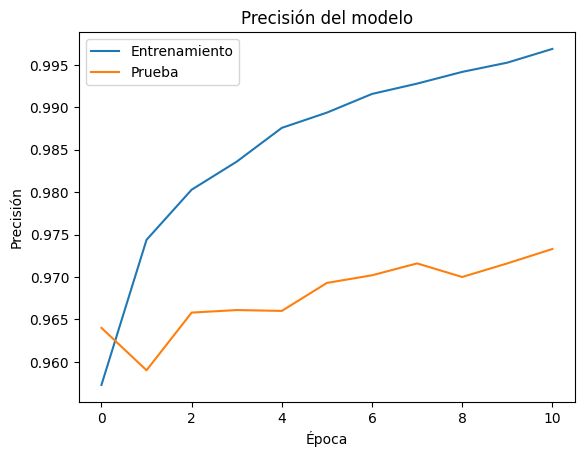

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

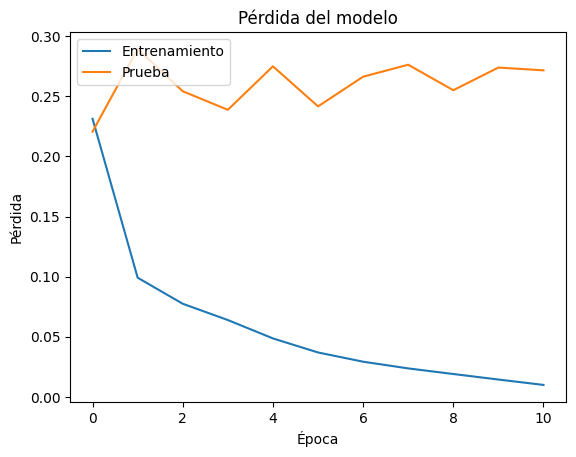

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

Hemos conseguido un modelo con un rendimiento del 99.69% en el conjunto de entrenamiento, y un rendimiento del 97.33% en el conjunto de test.

Podemos visualizar los resultados utilizando TensorBoard. Para ello, ejecutaremos el comando:

    tensorboard --logdir=./my_logs --port=6006

In [36]:
%load_ext tensorboard

In [37]:
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 4588), started 18:18:20 ago. (Use '!kill 4588' to kill it.)